# Web Scraping Job Vacancies Part 2


At the moment, I am extending the dataset from my previous web scraping project. In this phase, I intend to include major cities in Indonesia to observe the current trends and combine them into a single dataset. I generated a list of large cities programmatically to see the results. Most of the code used below is based on my earlier project, with the main addition being the inclusion of multiple cities to further analyze the effect.

## Step 1: Data Collection and Preparation


In [1]:
# Data handling and cleaning
import pandas as pd
import numpy as np

# Visualization libraries (commonly used for EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping essentials
import requests
from bs4 import BeautifulSoup

In [ ]:
base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

jobs = []

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/114.0.0.0 Safari/537.36"
}

In [ ]:
# List of big cities in Indonesia with latitude & longitude
indonesia_cities = [
    {"city": "Jakarta", "latitude": -6.2088, "longitude": 106.8456},
    {"city": "Surabaya", "latitude": -7.2575, "longitude": 112.7521},
    {"city": "Bandung", "latitude": -6.9175, "longitude": 107.6191},
    {"city": "Medan", "latitude": 3.5952, "longitude": 98.6722},
    {"city": "Semarang", "latitude": -6.9667, "longitude": 110.4167},
    {"city": "Palembang", "latitude": -2.9761, "longitude": 104.7754},
    {"city": "Makassar", "latitude": -5.1477, "longitude": 119.4327},
    {"city": "Tangerang", "latitude": -6.1783, "longitude": 106.6319},
    {"city": "Depok", "latitude": -6.4025, "longitude": 106.7942},
    {"city": "Bekasi", "latitude": -6.2349, "longitude": 106.9896},
    {"city": "Bogor", "latitude": -6.5971, "longitude": 106.8060},
    {"city": "Malang", "latitude": -7.9839, "longitude": 112.6214},
    {"city": "Denpasar", "latitude": -8.6705, "longitude": 115.2126},
    {"city": "Batam", "latitude": 1.0456, "longitude": 104.0305},
    {"city": "Pekanbaru", "latitude": 0.5071, "longitude": 101.4478},
    {"city": "Padang", "latitude": -0.9471, "longitude": 100.4172},
    {"city": "Banjarmasin", "latitude": -3.3167, "longitude": 114.5908},
    {"city": "Pontianak", "latitude": -0.0263, "longitude": 109.3425},
    {"city": "Manado", "latitude": 1.4748, "longitude": 124.8421},
    {"city": "Yogyakarta", "latitude": -7.7956, "longitude": 110.3695}
]


In [ ]:
def create_df_job ( keyword, location, max_page, data):
  MAX_PAGES = max_page #number of page to scan
  base_url = "https://id.jobstreet.com/id/{keyword}-jobs/in-{location}?page={page}"

  for page in range(1, MAX_PAGES + 1):
    url = base_url.format(keyword=keyword, location=location, page=page)
    print("Fetching:", url)

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print("Error:", response.status_code)
        break

    soup = BeautifulSoup(response.text, "html.parser")
    jobs = soup.find_all("article")

    if not jobs:
        print("No more jobs found, stopping.")
        break

    print(f"Page {page}: {len(jobs)} jobs found")

    for job in jobs:
        title = job.find("a", {"data-automation": "jobTitle"})
        classification = job.find("span", {"data-automation": "jobClassification"})
        company = job.find("a", {"data-automation": "jobCompany"})
        job_location = job.find("a", {"data-automation": "jobLocation"})
        postings = job.find("span", {"data-automation": "jobListingDate"})
        salary = job.find("span", {"data-automation": "jobSalary"})
        job_description = job.find("span", {"data-automation": "jobShortDescription"})

        # print(f"Title: {title.get_text(strip=True) if title else None}")
        # print(f"Company: {company.get_text(strip=True) if company else None}")
        # print(f"Location: {job_location.get_text(strip=True) if job_location else None}")
        # print(f"Posting: {postings.get_text(strip=True) if postings else None}")
        # print(f"Salary: {salary.get_text(strip=True) if salary else None}")
        # print("-" * 40)

        data.append({
              "Title": title.get_text(strip=True) if title else None,
              "Classification": classification.get_text(strip=True) if classification else None,
              "Company": company.get_text(strip=True) if company else None,
              "Location": job_location.get_text(strip=True) if job_location else None,
              "Posting": postings.get_text(strip=True) if postings else None,
              "Salary": salary.get_text(strip=True) if salary else None,
              "Description": job_description.get_text(strip=True) if job_description else None
          })
  return data


In [ ]:
import re

def normalize_number(s: str) -> float:
    """
    Convert salary string with commas/dots to float safely.
    Handles '1.000.000,10' and '1,000,000.10'.
    """
    # print(s)
    if s is None:
      return None
    if not re.search(r"\d", s):
      return None

    s = s.strip()

    # Case 1: European/Indonesian format → decimals with comma
    if re.search(r",\d{1,2}$", s):
        s = s.replace(".", "")       # remove thousands separator
        s = s.replace(",", ".")      # convert decimal comma to dot

    # Case 2: US format → decimals with dot
    elif re.search(r"\.\d{1,2}$", s):
        s = s.replace(",", "")       # remove thousands separator

    # Case 3: No decimals → just strip separators
    else:
        s = s.replace(".", "").replace(",", "")

    return float(s)


In [ ]:

def parse_salary(s):


    if pd.isna(s):
        return None, None, None,None


    if "per month" in s:
        unit = "month"
    elif "per year" in s:
        unit = "year"
    elif "per hour" in s:
        unit = "hour"
    else:
        unit = None

    if "Rp" in s:
       currency = "IDR"
    elif "$" in s:
        currency = "USD"
        convert = True
    elif "SGD" in s:
        currency = "SGD"
        convert = True
    else:
        currency = None


    s_clean = (s.strip().replace("Rp", "").replace("-", "–").replace("per month", "")
    .replace("per year", "").replace("per hour", "").replace("$", "").replace("(SGD)", "")
    .replace("(USD)", "").replace("IDR", "").replace("RM", "").replace("(MYR)", "")
    )
    low = None
    high = None
    if " – " in s_clean:
      s_clean = s_clean.split(" – ")
      low = s_clean[0]
      high = s_clean[1]
    else:
      low =s_clean
      high = s_clean


    return low,high, unit, currency






In [ ]:
df_job = []
for city in indonesia_cities:
  df_job.extend(create_df_job("Any",city["city"], 80))

In [ ]:
pd.DataFrame(df_job).to_csv("df_job.csv", index=False)

In [ ]:
df_job = pd.read_csv("df_job.csv")
df_job.head()

In [ ]:
df_job[["Salary_Low","Salary_High", "Unit", "Currency"]] = df_job["Salary"].apply(lambda x: pd.Series(parse_salary(x)))
df_job.head()

In [ ]:
df_job["Salary_Low"] = df_job["Salary_Low"].apply(lambda x: normalize_number(x))
df_job["Salary_High"] = df_job["Salary_High"].apply(lambda x: normalize_number(x))

In [ ]:
df_job.shape

(11933, 11)

**Amaziingg !!!**

With the maximum pages set for each city, the scraper generated over 11,000 job listings, which is significantly more than the previous dataset of only 2,560 entries. However, some cities do not have 80 pages of job postings, so the process stops earlier (for example, Medan only has 5 pages).

Note: The results may vary depending on the keyword. Currently, I am using the keyword “any” combined with city locations to generate the data. Using different keywords could produce different outcomes. Also, since job postings change over time, the dataset shown above reflects only the current snapshot of available jobs.

In [ ]:
df_job.to_csv("jobstreet_jobs_with_cities.csv", index=False, encoding="utf-8")

print("✅ Job data saved to jobstreet_jobs.csv")

✅ Job data saved to jobstreet_jobs.csv


## Step 2:Exploratory Data Analysis

In [2]:
file_path = 'https://raw.githubusercontent.com/Jasman123/Web_scraping_and_Job_Analyze/main/jobstreet_jobs_with_cities.csv'
df = pd.read_csv(file_path)
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
0,"Customer Service (Jakarta), Operations, SeaBank",(Call Center & Layanan Konsumen),PT Bank Seabank Indonesia,Jakarta Selatan,1 hari yang lalu,NaN,Carry out services to customers such as delive...,NaN,NaN,NaN,NaN
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR
3,Logistic,"(Manufaktur, Transportasi & Logistik)",NaN,Jakarta Raya,23 jam yang lalu,NaN,"Responsible of logistic from receipt, storage...",NaN,NaN,NaN,NaN
4,Customer Service Specialist,(Call Center & Layanan Konsumen),TE Connectivity,Jakarta Raya,16 jam yang lalu,NaN,"Involves demand planning, order management, cu...",NaN,NaN,NaN,NaN


In [3]:
print(f"Number of rows: {df.shape[0]}")
df = df.drop_duplicates()
print(f"Number of rows after removing duplicates: {df.shape[0]}")

Number of rows: 11933
Number of rows after removing duplicates: 5228


The code executes drop_duplicates and shows that a significant portion **(more than 50%)** of the dataset has duplicate entries.

Why does this happen?
One possibility is that some of the cities are very close to each other (for example, Jakarta–Depok, which are about 29 km apart), causing job board openings to be duplicated.

In [4]:
df.dtypes

,0
Title,object
Classification,object
Company,object
Location,object
Posting,object
Salary,object
Description,object
Salary_Low,float64
Salary_High,float64
Unit,object


In [5]:
df.describe()

,Salary_Low,Salary_High
count,7.890000e+02,7.890000e+02
mean,7.521840e+06,9.831156e+06
std,9.526425e+06,1.362238e+07
min,2.500000e+03,3.000000e+03
25%,4.500000e+06,5.500000e+06
50%,6.000000e+06,7.500000e+06
75%,8.000000e+06,1.000000e+07
max,2.000000e+08,3.000000e+08


In [6]:
df.isnull().sum()

,0
Title,0
Classification,0
Company,116
Location,0
Posting,0
Salary,4437
Description,1
Salary_Low,4439
Salary_High,4439
Unit,4440


In [7]:
no_salary = float(df["Salary"].isnull().sum()) / len(df) * 100
print(f"Missing salary values: {no_salary:.2f}%")

Missing salary values: 84.87%


In [8]:
no_company = df["Company"].nunique()
print(f"numbers of company: {no_company}")

numbers of company: 2218


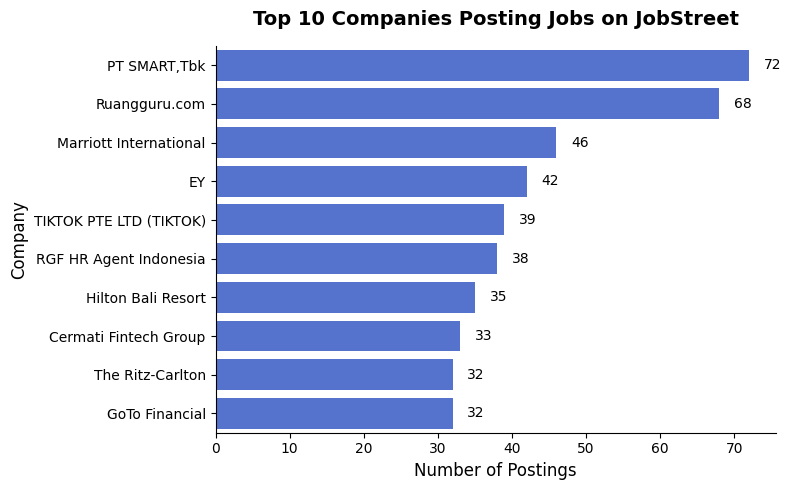

In [9]:
# Top 10 companies with most job postings
df_top10_company = df["Company"].value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(
    y=df_top10_company.index,
    x=df_top10_company.values,
    color="royalblue"
)

# Add value labels on bars
for i, val in enumerate(df_top10_company.values):
    plt.text(val + 2, i, str(val), va='center', fontsize=10)

# Labels and title
plt.ylabel("Company", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Companies Posting Jobs on JobStreet", fontsize=14, fontweight="bold", pad=15)

sns.despine()
plt.tight_layout()
plt.show()

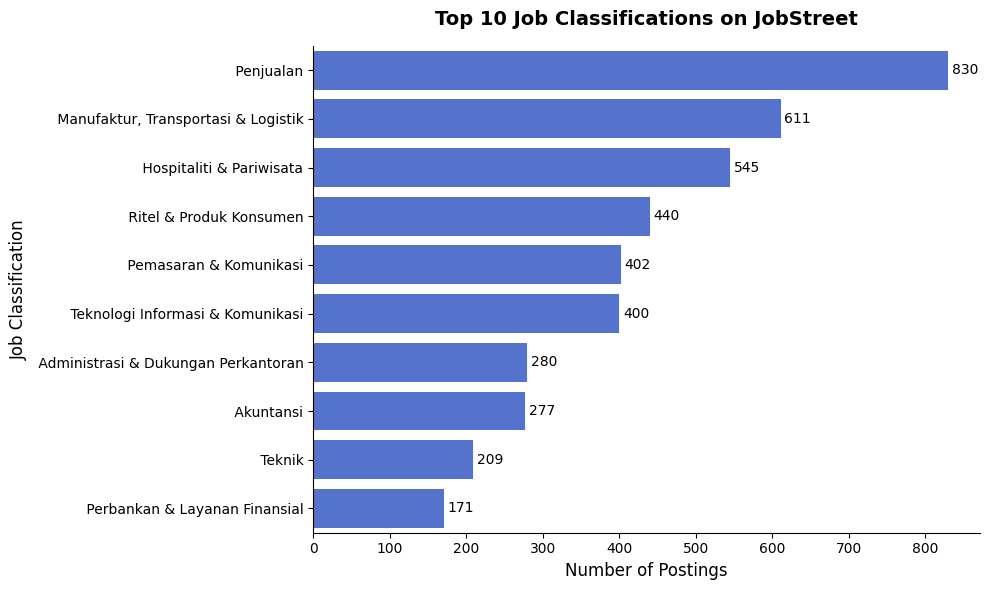

In [10]:
df_top10job = df["Classification"].value_counts().head(10).reset_index()
df_top10job.columns = [ "Classification", "Sum of Postings"]
df_top10job['Classification'] = df_top10job['Classification'].str.replace(
    r"\((.*)\)", r" \1", regex=True
)

plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_top10job,
    y="Classification",
    x="Sum of Postings",
    color="royalblue"
)

# Add value labels
for i, val in enumerate(df_top10job["Sum of Postings"]):
    plt.text(val + 5, i, str(val), va="center", fontsize=10)

plt.ylabel("Job Classification", fontsize=12)
plt.xlabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Classifications on JobStreet", fontsize=14, fontweight="bold", pad=15)
sns.despine()
plt.tight_layout()
plt.show()

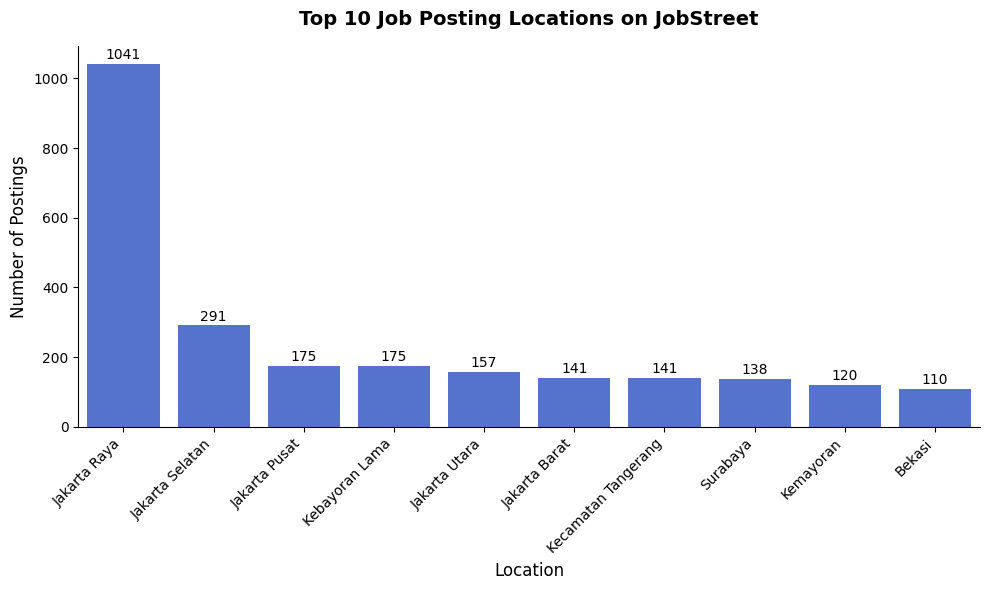

In [11]:
df_top10_location = df["Location"].value_counts().head(10)
# df_top10_location
plt.figure(figsize=(10,6))
sns.barplot(
    x=df_top10_location.index,
    y=df_top10_location.values,
    color="royalblue"  # one consistent color
)

# Add labels on top of bars
for i, val in enumerate(df_top10_location.values):
    plt.text(i, val + 5, str(val), ha='center', va='bottom', fontsize=10)

plt.xlabel("Location", fontsize=12)
plt.ylabel("Number of Postings", fontsize=12)
plt.title("Top 10 Job Posting Locations on JobStreet", fontsize=14, fontweight="bold", pad=15)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()

In [12]:
df = df[df['Unit']=='month']

In [13]:
max_salary = df['Salary_High'].max()
min_salary = df['Salary_Low'].min()

print(f"Maximum Salary: {max_salary}")
print(f"Minimum Salary: {min_salary}")

Maximum Salary: 130000000.0
Minimum Salary: 2500.0


In [14]:
df_max = df[df['Salary_High'] == max_salary]
df_max

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
802,Vice President of Corporate Relations,(CEO & Manajemen Umum),PT Humana International Indonesia,Jakarta Raya,6 hari yang lalu,Rp 100.000.000 – Rp 130.000.000 per month,Develop and execute strategies to build and st...,100000000.0,130000000.0,month,IDR


<Axes: xlabel='Salary_Low', ylabel='Count'>

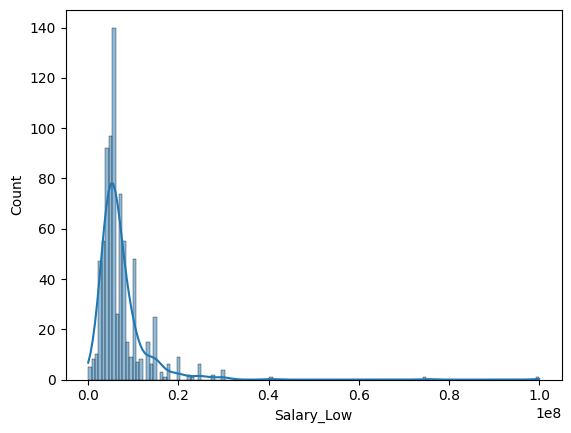

In [15]:
sns.histplot(df['Salary_Low'], kde=True)

In [16]:
q = df['Salary_Low'].quantile(0.01)
df_min = df[df['Salary_Low'] >= q]
min_salary = df_min['Salary_Low'].min()
min_salary

1500000.0

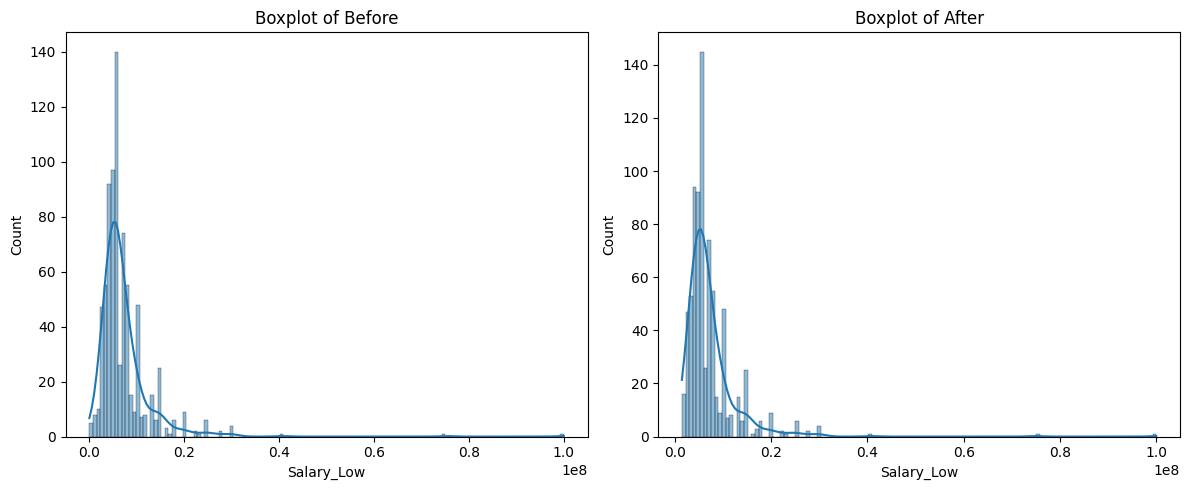

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df, x='Salary_Low', ax=ax[0], kde=True)
ax[0].set_title('Boxplot of Before')

sns.histplot(data=df_min, x='Salary_Low', ax=ax[1], kde=True)
ax[1].set_title('Boxplot of After')

plt.tight_layout()
plt.show()


In [18]:
df_min = df[df['Salary_Low'] == min_salary]
df_min

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency
952,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,19 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
1324,Graphic Designer Intern,(Desain & Arsitektur),Hey Coco! Creative Agency,Jakarta Barat,14 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,We are Hey Coco! Creative Agency based on West...,1500000.0,2000000.0,month,IDR
1736,Legal Internship,(Hukum),PT Exabytes Network Indonesia,Jakarta Selatan,29 hari yang lalu,Rp 1.500.000 per month,"As a Legal Intern, you will be an integral par...",1500000.0,1500000.0,month,IDR
4061,Writer,"(Periklanan, Seni & Media)",PT Aldmic Indonesia,Jakarta Barat,20 jam yang lalu,Rp 1.500.000 – Rp 1.760.000 per month,team work,1500000.0,1760000.0,month,IDR
11553,Costumer Services Onine,(Call Center & Layanan Konsumen),Pondok Digital,Kubu Raya,19 jam yang lalu,Rp 1.500.000 – Rp 2.200.000 per month,Bekerja sambil beramal dan berdakwah,1500000.0,2200000.0,month,IDR
11633,SOZO - APOTEKER PENANGGUNG JAWAB (MANADO) - NO...,(Kesehatan & Medis),SEVEN Retail Group,Manado,24 hari yang lalu,Rp 1.500.000 – Rp 2.000.000 per month,"Tidak bekerja di klinik secara langsung, hanya...",1500000.0,2000000.0,month,IDR


In [19]:
df['Average_salary'] = (df['Salary_High'] + df['Salary_Low']) / 2

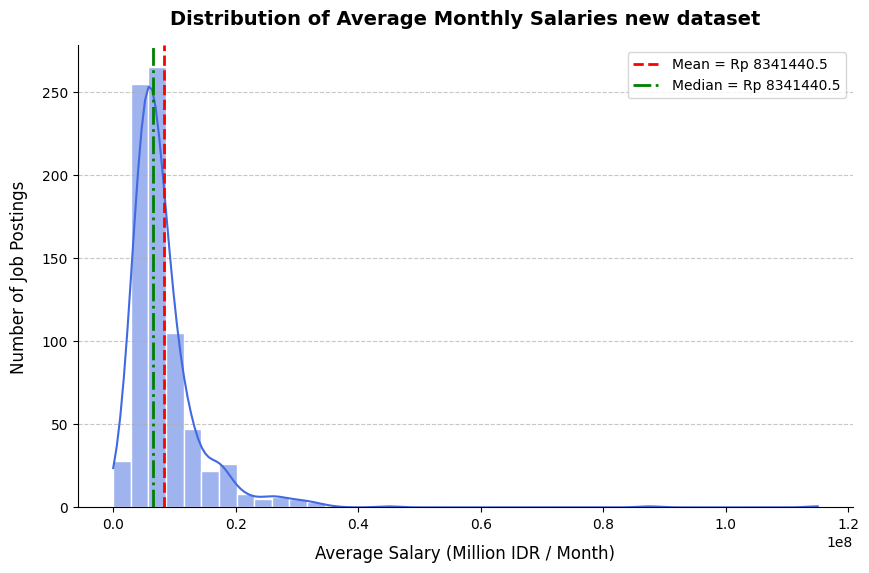

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(df['Average_salary'], bins=40, kde=True, color="royalblue", edgecolor="white")
plt.xlabel("Average Salary (Million IDR / Month)", fontsize=12, labelpad=10)
plt.ylabel("Number of Job Postings", fontsize=12, labelpad=10)
plt.title("Distribution of Average Monthly Salaries new dataset", fontsize=14, fontweight="bold", pad=15)
plt.axvline(df['Average_salary'].mean(), color="red", linestyle="--", linewidth=2, label=f"Mean = Rp {df['Average_salary'].mean():.1f}")
plt.axvline(df['Average_salary'].median(), color="green", linestyle="-.", linewidth=2, label=f"Median = Rp {df['Average_salary'].mean():.1f}")

plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine()
plt.show()

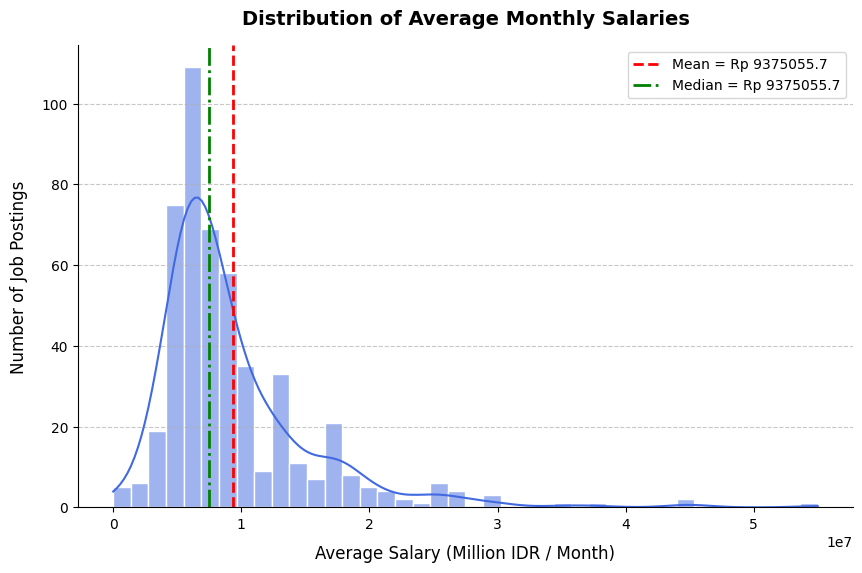

***Insight***

From the two images, we can observe several differences after generating the new dataset for visualization. I would like to highlight a few key points:



1.  **Longer tail in the new dataset:** The first image shows a longer tail compared to the old dataset, extending up to a maximum salary value of around 130 million rupiah, while the previous version only reached about 65 million rupiah.

2. **Shift in mean and median:** Another noticeable change is the shift in the mean and median values between the two graphs. The average salary decreased from approximately 9 million rupiah to 8 million rupiah. This shift occurred because Indonesia applies different minimum wage standards across cities. When these segmented data are compiled together, the mean and median values move leftward. For instance, Jakarta has a monthly minimum wage of Rp 5,396,761, whereas Medan’s is Rp 4,014,072.

## Step 3: Machine Learning Implementation on Predicting Job Salary

In [21]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"(Manufaktur, Transportasi & Logistik)",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"(Manufaktur, Transportasi & Logistik)",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,(Administrasi & Dukungan Perkantoran),PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"(Periklanan, Seni & Media)",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,(Call Center & Layanan Konsumen),redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [22]:
df.shape

(779, 12)

In [23]:
df['Classification'] = df['Classification'].str.replace(r"\((.*)\)", r" \1", regex=True)

In [24]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta Selatan,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta Selatan,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta Utara,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,Jakarta Raya,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta Raya,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0


In [25]:
string_cities = df['Location'].value_counts().to_string()
print(string_cities)

Location
Jakarta Raya           87
Jakarta Selatan        81
Jakarta Utara          56
Jakarta Pusat          48
Bali                   42
Jakarta Barat          39
Badung                 29
Manado                 25
Surabaya               21
Tangerang              17
Semarang               17
Bandung                15
Jakarta Timur          12
Karawang               12
Denpasar               12
Cikarang Pusat         11
Tangerang Selatan      11
Batam                  11
Makassar               10
Palembang              10
Pekanbaru              10
Cikarang Selatan       10
Cikarang                9
Pontianak               9
Bekasi                  8
Medan                   7
Kalimantan Barat        6
Kuta Utara              6
Sidoarjo                6
Jawa Timur              5
Ubud                    5
Denpasar Barat          5
Malang                  5
Padang                  5
Kabupaten Tangerang     5
Banjarmasin             4
Kabupaten Bekasi        4
Banten                  4
Kut

In [26]:
df.loc[df['Location'].str.contains("Jakarta", case=False), 'Location'] = "Jakarta"
df.loc[df['Location'].str.contains("Bekasi", case=False), 'Location'] = "Bekasi"
df.loc[df['Location'].str.contains("Cikarang", case=False), 'Location'] = "Cikarang"
df.loc[df['Location'].str.contains("Bandung", case=False), 'Location'] = "Bandung"
df.loc[df['Location'].str.contains("Bogor", case=False), 'Location'] = "Bogor"
df.loc[df['Location'].str.contains("Depok", case=False), 'Location'] = "Depok"
df.loc[df['Location'].str.contains("Badung", case=False), 'Location'] = "Bandung"
df.loc[df['Location'].str.contains("Tangerang", case=False), 'Location'] = "Tangerang"

In [27]:
string_cities = df['Location'].value_counts().to_string()
top20_cities = df['Location'].value_counts().nlargest(20).index.tolist()
print(top20_cities)

['Jakarta', 'Bandung', 'Bali', 'Tangerang', 'Cikarang', 'Manado', 'Surabaya', 'Semarang', 'Bekasi', 'Karawang', 'Denpasar', 'Batam', 'Pekanbaru', 'Makassar', 'Palembang', 'Pontianak', 'Medan', 'Kuta Utara', 'Kalimantan Barat', 'Sidoarjo']


In [28]:
df = df[df['Location'].isin(top20_cities)]
df.shape

(651, 12)

In [29]:
df['Classification'].value_counts()

,count
Classification,
Penjualan,138
"Manufaktur, Transportasi & Logistik",86
Pemasaran & Komunikasi,53
Administrasi & Dukungan Perkantoran,48
Ritel & Produk Konsumen,45
Hospitaliti & Pariwisata,40
Teknologi Informasi & Komunikasi,34
Akuntansi,30
Teknik,27


manager, admin, Engineer, Executive, Marketing, supervisor, staff, speaker, Specialist,Senior,

In [30]:
df['Classification'] = df['Classification'].str.strip()
df_review = df[df['Classification']=='Administrasi & Dukungan Perkantoran']
for i in df_review['Title'].unique():
  print(i)

Sales Admin
Visa & Document Staff
Outbound Document Staff
PERSONAL ASSISTANT CEO
Logistic and/or Sales Admin Staff
Marketing Support - Jakarta - WFO (ID: 683261)
Administrative Executive (MANDARIN SPEAKER)
Korean Translator
In-house Translators (Penerjemahan Internal)
Personal Assistant to General Manager
Sales & Interpreter Staff (Mandarin Speaker) - Real Estate (A-122675)
Japanese Interpreter - Finance (A-122690)
Translator Mandarin
MANDARIN ASSISTANT & TRANSLATOR
Sales Administration (Staff)
Executive Assistant
Receptionist (Mandarin speaker)
Personal Assistant
Formalities Officer (Customer Service)
Visa Officer
Business Assistant
ADMIN SALES
SALES ADMIN
Corporate Secretary
Young Professionals - Work From Home (WFH)
Business Planning Administration
Administration (Bandung)
Japanese Interpreter - Manufacturing (A-122334)
PROJECT SECRETARY
Client Work Visa Processing Officer
SECRETARY
Sales Administration / Customer Service - Trading - Bekasi (C-122822)
Marketing Administrator (Import

In [170]:
import re
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization


def custom_standardization(text):
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, r"http\S+", "")
    text = tf.strings.regex_replace(text, r"[^a-z\s]", "")
    text = tf.strings.regex_replace(text, r"\s+", " ")
    return text

In [171]:
df.head()

,Title,Classification,Company,Location,Posting,Salary,Description,Salary_Low,Salary_High,Unit,Currency,Average_salary,Position_level
1,Young Professionals Fast Track,"Manufaktur, Transportasi & Logistik",Deliveree (PT Angkut Teknologi Indonesia),Jakarta,1 hari yang lalu,"Rp 6,000,000 – Rp 9,000,000 per month","If you just click apply, you will not receive ...",6000000.0,9000000.0,month,IDR,7500000.0,Mid
2,Customer Service and Operation Specialist (Air...,"Manufaktur, Transportasi & Logistik",Easy Speed International Logistics Limited,Jakarta,3 hari yang lalu,"Rp 8,000,000 – Rp 12,000,000 per month",Airfreight customer service and import and exp...,8000000.0,12000000.0,month,IDR,10000000.0,Mid
5,Sales Admin,Administrasi & Dukungan Perkantoran,PT AAF International Indonesia,Jakarta,10 hari yang lalu,"Rp 5,000,000 – Rp 7,000,000 per month",Sales Admin plays a crucial role in supporting...,5000000.0,7000000.0,month,IDR,6000000.0,Mid
6,Senior Videographer (Singapore),"Periklanan, Seni & Media",Boom Digital Media,Jakarta,14 hari yang lalu,"$5,000 – $7,500 per month (SGD)",This job will be based in Singapore. The work ...,5000.0,7500.0,month,USD,6250.0,Entry
8,Customer Service - Assistant Manager,Call Center & Layanan Konsumen,redBus,Jakarta,1 hari yang lalu,"Rp 11,000,000 – Rp 14,000,000 per month",Hiring for CS Asst. Manager to lead vendor-man...,11000000.0,14000000.0,month,IDR,12500000.0,Senior


In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651 entries, 1 to 11693
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Title           651 non-null    object  
 1   Classification  651 non-null    object  
 2   Company         616 non-null    object  
 3   Location        651 non-null    object  
 4   Posting         651 non-null    object  
 5   Salary          651 non-null    object  
 6   Description     651 non-null    object  
 7   Salary_Low      651 non-null    float64 
 8   Salary_High     651 non-null    float64 
 9   Unit            651 non-null    object  
 10  Currency        650 non-null    object  
 11  Average_salary  651 non-null    float64 
 12  Position_level  651 non-null    category
dtypes: category(1), float64(3), object(9)
memory usage: 83.1+ KB


In [173]:
from sklearn.model_selection import train_test_split

X = df[['Title','Classification','Company','Location','Unit','Currency']]
y = df['Average_salary']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(520, 6)
(131, 6)
(520,)
(131,)


In [174]:
X_train.head()

,Title,Classification,Company,Location,Unit,Currency
87,Marketing Support - Jakarta - WFO (ID: 683261),Administrasi & Dukungan Perkantoran,PT. PERSOLKELLY Recruitment Indonesia,Jakarta,month,IDR
2123,Backend Developer Golang for Banking Industry,Teknologi Informasi & Komunikasi,PT. SIGMA GLOBAL TEKNOLOGI (SIGMATECH),Jakarta,month,IDR
2172,Purchasing Staff ( Mandarin Speaker ),"Manufaktur, Transportasi & Logistik",Swap Energi Indonesia .PT,Jakarta,month,IDR
877,Retail Operation Manager,Ritel & Produk Konsumen,PT MGI GAYA HIDUP MANAJEMEN,Jakarta,month,IDR
1950,E-Commerce Specialist,Pemasaran & Komunikasi,PT Merdis International,Jakarta,month,IDR


In [175]:
X_train["Combined_text"] = ""
X_test["Combined_text"] = ""

for column in X_train.columns:
    X_train[column] = X_train[column].fillna('').apply(custom_standardization)
    X_test[column] = X_test[column].fillna('').apply(custom_standardization)

    X_train["Combined_text"] += X_train[column]
    X_test["Combined_text"] += X_test[column]

    print(column)

Title
Classification
Company
Location
Unit
Currency
Combined_text


In [176]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1,1))

train_ds = tf.data.Dataset.from_tensor_slices((X_train["Combined_text"].astype(str).values, y_train_scaled))
val_ds   = tf.data.Dataset.from_tensor_slices((X_test["Combined_text"].astype(str).values, y_test_scaled))

train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)


In [177]:
MAX_VOCAB = 200000
SEQ_LENGTH = 200

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_VOCAB,
    output_mode='int',
    output_sequence_length=SEQ_LENGTH
)

In [178]:
vectorize_layer.adapt(train_ds.map(lambda text, label: text))

In [179]:
vectorize_layer.get_vocabulary()[:5]

['',
 '[UNK]',
 np.str_('transportasi'),
 np.str_('komunikasipt'),
 np.str_('logistikpt')]

In [180]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Dropout

model = Sequential([
    vectorize_layer,
    Embedding(MAX_VOCAB, 128, mask_zero=True),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1)
])


In [181]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile BEFORE training
model.compile(
    loss="mse",
    optimizer="adam",
    metrics=["mae"]
)

# Early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop]
)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - loss: 0.0061 - mae: 0.0567 - val_loss: 0.0019 - val_mae: 0.0273
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 482ms/step - loss: 0.0052 - mae: 0.0328 - val_loss: 0.0016 - val_mae: 0.0292
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - loss: 0.0033 - mae: 0.0262 - val_loss: 0.0018 - val_mae: 0.0319
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 510ms/step - loss: 0.0024 - mae: 0.0236 - val_loss: 0.0018 - val_mae: 0.0320
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - loss: 0.0021 - mae: 0.0228 - val_loss: 0.0021 - val_mae: 0.0323
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - loss: 0.0014 - mae: 0.0198 - val_loss: 0.0018 - val_mae: 0.0292
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 530ms/step - loss: 8.6999e-04 - mae: 0.0180 - val_loss: 0.0017 - val_mae: 0.0278


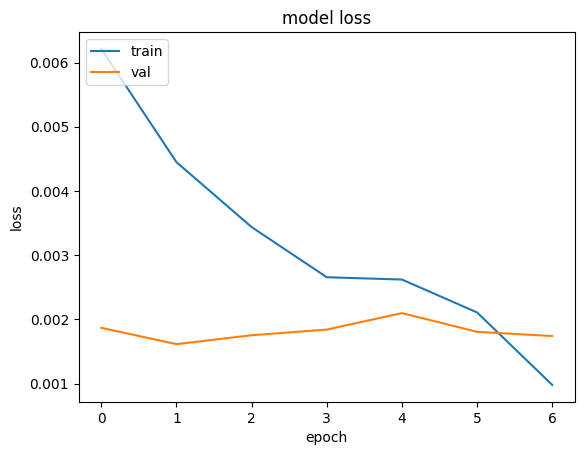

In [182]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [183]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [184]:
y_pred = model.predict(val_ds).reshape(-1)
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true).reshape(-1)

y_pred_real = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_real = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()


import pandas as pd
results_df = pd.DataFrame({
    "Actual_Salary": y_true_real,
    "Predicted_Salary": y_pred_real,
    "Residual": y_true_real - y_pred_real,
    "Percentage_Error": ((y_true_real - y_pred_real) / y_true_real) * 100
})

print(results_df.head(10))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
   Actual_Salary  Predicted_Salary   Residual  Percentage_Error
0      5750000.0         7955682.5 -2205682.5        -38.359696
1      5500000.0         8122005.5 -2622005.5        -47.672827
2     12750000.0         8608246.0  4141754.0         32.484345
3      9500000.0        10424893.0  -924893.0         -9.735716
4      4000000.0        13994576.0 -9994576.0       -249.864400
5      5250000.0         6862234.0 -1612234.0        -30.709219
6      6000000.0         9492453.0 -3492453.0        -58.207550
7      7950000.0         7909915.0    40085.0          0.504214
8      6250000.0         8054925.0 -1804925.0        -28.878800
9      6500000.0         6235872.5   264127.5          4.063500


Standard Deviation of Residuals: 5,286,235


/tmp/ipython-input-3419340829.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


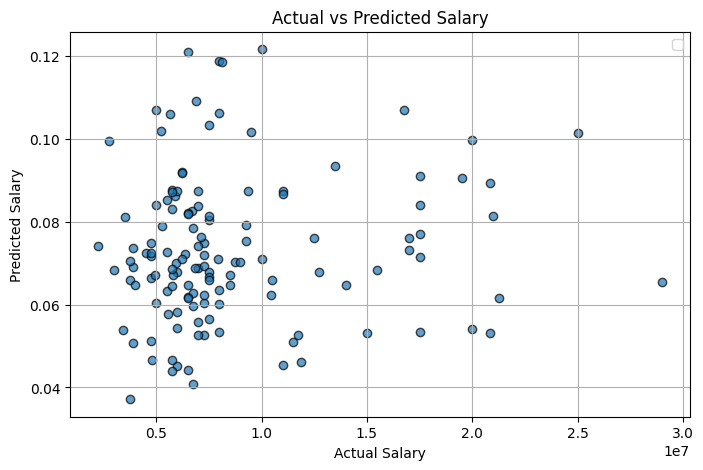

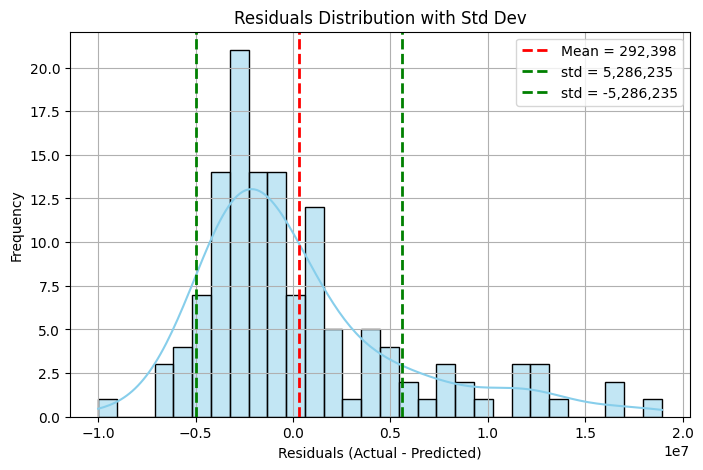

In [185]:
# Residuals (errors)
residuals = results_df['Residual']
std_margin = residuals.std()
print(f"Standard Deviation of Residuals: {std_margin:,.0f}")

# --- Scatter plot: Actual vs Predicted ---
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")

# # Reference line (perfect prediction)
# plt.plot([y_test.min(), y_test.max()],
#          [y_test.min(), y_test.max()],
#          'r--', lw=2, label="Perfect prediction")

plt.legend()
plt.grid(True)
plt.show()

# --- Residuals distribution with std ---
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color="skyblue")

# Add vertical lines for mean and ± std
plt.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, label=f"Mean = {residuals.mean():,.0f}")
plt.axvline(residuals.mean() + std_margin, color='green', linestyle='--', linewidth=2, label=f"std = {std_margin:,.0f}")
plt.axvline(residuals.mean() - std_margin, color='green', linestyle='--', linewidth=2, label=f"std = {-1*std_margin:,.0f}")

plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution with Std Dev")
plt.legend()
plt.grid(True)
plt.show()

In [186]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
print("RMSE:", np.sqrt(mean_squared_error(results_df['Predicted_Salary'], results_df['Actual_Salary'])))
print("R² Score:", r2_score(results_df['Predicted_Salary'], results_df['Actual_Salary']))

RMSE: 5274131.74115625
R² Score: -5.724763961402458


In [188]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- 1. Prepare data ---
df["Combined_text"] = (
    df["Title"].fillna('') + " " +
    df["Classification"].fillna('') + " " +
    df["Company"].fillna('') + " " +
    df["Location"].fillna('')
)

X = df["Combined_text"]
y = df["Average_salary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 2. Build pipeline ---
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=10000, ngram_range=(1,2))),
    ("rf", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# --- 3. Train ---
pipeline.fit(X_train, y_train)

# --- 4. Predict ---
y_pred = pipeline.predict(X_test)

# --- 5. Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"R² Score: {r2:.4f}")

# --- 6. Results DataFrame ---
results_df = pd.DataFrame({
    "Actual_Salary": y_test.values,
    "Predicted_Salary": y_pred,
    "Residual": y_test.values - y_pred,
    "Percentage_Error": ((y_test.values - y_pred) / y_test.values) * 100
})

print(results_df.head(10))

RMSE: 4,727,571
R² Score: 0.1085
   Actual_Salary  Predicted_Salary      Residual  Percentage_Error
0      3900000.0      4.067975e+06 -1.679750e+05         -4.307051
1      3750000.0      6.591306e+06 -2.841306e+06        -75.768159
2      7250000.0      6.479059e+06  7.709407e+05         10.633665
3     19500000.0      5.874876e+06  1.362512e+07         69.872432
4     10000000.0      7.936250e+06  2.063750e+06         20.637500
5      6750000.0      6.842231e+06 -9.223133e+04         -1.366390
6      6700000.0      1.025250e+07 -3.552500e+06        -53.022388
7      7000000.0      7.551862e+06 -5.518623e+05         -7.883748
8      5950000.0      8.457099e+06 -2.507099e+06        -42.136124
9     20000000.0      1.359750e+07  6.402500e+06         32.012500


In [191]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

# --- 1. Prepare data ---
df["Combined_text"] = (
    df["Title"].fillna('') + " " +
    df["Classification"].fillna('') + " " +
    df["Company"].fillna('') + " " +
    df["Location"].fillna('')
)

X = df["Combined_text"]
y = df["Average_salary"]

# Log-transform target
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# --- 2. TF-IDF Vectorization ---
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# --- 3. LightGBM model ---
lgbm = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

# --- 4. Train ---
lgbm.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_test_tfidf, y_test)],
    eval_metric="rmse",
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

# --- 5. Predict (inverse log-transform) ---
y_pred_log = lgbm.predict(X_test_tfidf)
y_pred = np.expm1(y_pred_log)   # back to real salary
y_true = np.expm1(y_test)       # inverse transform for comparison

# --- 6. Evaluation ---
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:,.0f}")
print(f"R² Score: {r2:.4f}")

# --- 7. Results DataFrame ---
results_df = pd.DataFrame({
    "Actual_Salary": y_true,
    "Predicted_Salary": y_pred,
    "Residual": y_true - y_pred,
    "Percentage_Error": ((y_true - y_pred) / y_true) * 100
})

print(results_df.head(10))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1230
[LightGBM] [Info] Number of data points in the train set: 520, number of used features: 70
[LightGBM] [Info] Start training from score 15.730104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


TypeError: got an unexpected keyword argument 'squared'